In [1]:
import arviz as az
import io
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import pymc as pm
import pytensor.tensor as pt
import requests
import statsmodels.api as sm
import warnings
import xarray as xr

In [2]:
countries_iso = ['BEL', 'DNK', 'FRA', 'GBR', 'ITA', 'NLD', 'NOR', 'PRT']
countries_names = ['Belgium', 'Denmark', 'France', 'United Kingdom', 'Italy',
                   'Netherlands', 'Norway', 'Portugal']

In [3]:
data_path = Path(Path.cwd().parent / "data processed" / "nato_dataset.csv")
print("NATO dataset")
print("Full file path: ",data_path)
print("File exists: ",data_path.exists())

NATO dataset
Full file path:  /Users/awalters/escp_phd/govt_spending/data processed/nato_dataset.csv
File exists:  True


In [4]:
df = pd.read_csv(data_path)

In [5]:
def build_panel_var_design_fast(df, y_vars, p=1):
    df = df.copy()
    df["year"] = pd.to_numeric(df["year"], errors="coerce")
    df = df.dropna(subset=["iso", "year"])
    df = df.sort_values(["iso", "year"])

    pieces = []
    for iso, g in df.groupby("iso", sort=False):
        g = g.sort_values("year")
        Yg = g[y_vars]

        # create all lags at once (no fragmentation)
        lagged = pd.concat(
            {f"L{l}": Yg.shift(l) for l in range(1, p + 1)},
            axis=1
        )
        # flatten MultiIndex columns: (L#, var) -> var_L#
        lagged.columns = [f"{var}_{lag}" for lag, var in lagged.columns]

        out = pd.concat([g[["iso", "year"] + y_vars], lagged], axis=1)
        pieces.append(out)

    d = pd.concat(pieces, axis=0)

    lag_cols = [f"{v}_L{l}" for l in range(1, p + 1) for v in y_vars]
    d = d.dropna(subset=y_vars + lag_cols).copy()

    countries = np.array(sorted(d["iso"].unique()))
    iso_to_idx = {iso: i for i, iso in enumerate(countries)}
    c_idx = d["iso"].map(iso_to_idx).to_numpy()

    Y = d[y_vars].to_numpy()
    X = d[lag_cols].to_numpy()  # only lags => BVAR (no exog, no const)

    return Y, X, c_idx, countries, d

In [6]:
p = 15

y_vars = [
    "mil_delta",
    "log_gov_pc",
    "log_rgdp_pc",
    "tbill",
    "log_tfp",
    "def_gdp",
    "debt_gdp",
]

Y, X, c_idx, countries, d_used = build_panel_var_design_fast(df, y_vars=y_vars, p=15)


N, K = Y.shape
M = X.shape[1]
print("N,K,M =", N, K, M, "  K*p =", K*p)

N,K,M = 715 7 105   K*p = 105


In [7]:
Y_mean = Y.mean(axis=0)
Y_std  = Y.std(axis=0, ddof=0)
Yz = (Y - Y_mean) / Y_std

X_mean = X.mean(axis=0)
X_std  = X.std(axis=0, ddof=0)
X_std[X_std == 0] = 1.0
Xz = (X - X_mean) / X_std

In [8]:
lam1, lam2, lam3 = 0.2, 0.5, 1.0

prior_mu = np.zeros((M, K))
prior_sd = np.zeros((M, K))

for l in range(1, p + 1):
    base = lam1 / (l ** lam3)
    for j in range(K):              # predictor var
        row = (l - 1) * K + j
        for k in range(K):          # equation
            if l == 1 and j == k:
                prior_mu[row, k] = 1.0
            prior_sd[row, k] = base if (j == k) else (base * lam2)

In [9]:
C = len(countries)

with pm.Model() as panel_bvar:
    X_data = pm.Data("X", Xz)
    Y_data = pm.Data("Y", Yz)
    c_data = pm.Data("c_idx", c_idx)

    alpha = pm.Normal("alpha", 0.0, 1.0, shape=(C, K))
    B     = pm.Normal("B", mu=prior_mu, sigma=prior_sd, shape=(M, K))

    L, corr, sigmas = pm.LKJCholeskyCov(
        "L", n=K, eta=2.0,
        sd_dist=pm.Exponential.dist(1.0),
        compute_corr=True,
    )

    mu = alpha[c_data] + pm.math.dot(X_data, B)
    y  = pm.MvNormal("y", mu=mu, chol=L, observed=Y_data)

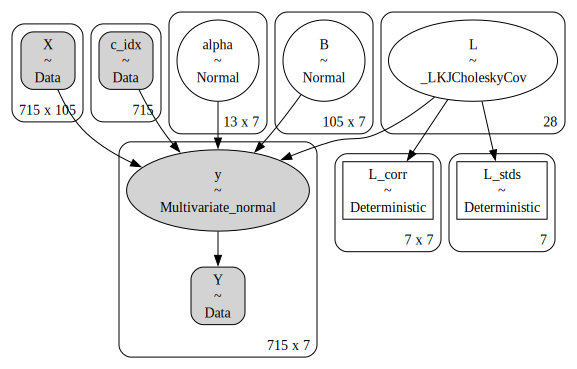

In [10]:
pm.model_to_graphviz(panel_bvar)

In [ ]:
with panel_bvar:
    trace = pm.sample(
        draws=1000,
        tune=1000,
        chains=10,
        cores=10,
        target_accept=0.95,
        mp_ctx="spawn",          # <-- macOS often happier with spawn
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 10 jobs)
NUTS: [alpha, B, L]


Output()

/Users/awalters/miniforge3/envs/escp_phd/lib/python3.11/site-packages/pytensor/compile/function/types.py:1038: RuntimeWarning: invalid value encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)
